# Sharpe Momentum Trading Strategies

Simeon Bikorimana

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.spatial.distance as distance
import statsmodels.api as sm
from statsmodels import regression
import time
from datetime import datetime, date, time, timedelta

/Users/jennyTian/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data = pd.read_csv('/Users/jennyTian/Desktop/ts project/all_stocks_5yr.csv').set_index('date')
data = data[['close','Name']]
data.head()
#data[data['Name'] == 'AAL'].index
#len(set(data.Name.values))

,close,Name
date,,
2013-02-08,14.75,AAL
2013-02-11,14.46,AAL
2013-02-12,14.27,AAL
2013-02-13,14.66,AAL
2013-02-14,13.99,AAL


In [3]:
SP500 = pd.read_csv('/Users/jennyTian/Desktop/ts project/^GSPC.csv').set_index('Date')
SP500 = SP500['Adj Close']
SP500.head()
len(SP500)

1259

In [4]:
# Timeline of changing holding position
index = pd.to_datetime(data[data['Name'] == 'AAL'].index)
timeline = index[20::10]

# There are total 505 stocks in SP500
symbols = set(data['Name'].values)
symbols = sorted(list(symbols))

In [5]:
def sharperank(data,time):
    """
    Function:   This function rank the returns of all stocks in the last 20 days
    Input:      data
                the time we decide to change the position
    Output:     buylist of the companies we decide to choose base on the current sharpe ratio rank
    """
    
    data.index = pd.to_datetime(data.index)
    sharpe = {'symbol':[], 'ratio':[]}
    for symbol in symbols:
        sharpe['symbol'].append(symbol)
        chunckdata = data[data['Name'] == symbol]
        chunckdata = chunckdata[(chunckdata.index >= (time - timedelta(20))) & (chunckdata.index <= time)]
        
        # get sharpe ratios of all stocks
        ret = chunckdata[chunckdata['Name'] == symbol]['close'].pct_change().dropna()
        ratio = ret.mean() / ret.std()
        sharpe['ratio'].append(ratio)
        
    # sort sharpe ratios
    sharpe = pd.DataFrame(sharpe)
    sorted_sharpe = sharpe.sort_values(by = ['ratio'],ascending = False)
    sorted_sharpe = sorted_sharpe.reset_index()
        
    # According to the ranks, choose to long the top 10% stocks
    sorted_sharpe = sorted_sharpe[0:int(sorted_sharpe.shape[0]*1/5)]
    buylist = sorted_sharpe['symbol'].tolist()
    return(buylist)

In [6]:
def valid_companies(buylist):
    """
    Function: This funciton checks whether this timeline has this stock
    Input:    buylist we get from sharpe rank function
    Output:   number of the buylist
              valid new buylist
    """
    
    buylist_new = []
    for buy in buylist:
        if timeline[0] in (data[data['Name'] == buy].index):
            buylist_new.append(buy)
    number = len(buylist_new)
    return(number,buylist_new)

In [7]:
capital_base = 1000000

capital_change = []
for i in np.arange(len(timeline)-1):
    pricelist = []
    sharelist = []
    # get the new buylist
    buylist = sharperank(data,timeline[i])
    number, buylist_new = valid_companies(buylist)
   
    # get the money we put in each stock. Here we use equal holding position
    money = capital_base / number
    
    # Buy stocks we choose
    for buy in buylist_new:
        price = data[data['Name'] == buy][data[data['Name'] == buy].index == timeline[i]]['close'].values[0]
        # floor down to integer shares
        share = int(money / price)
        sharelist.append(share)
        pricelist.append(price)  
        
    moneyleft = capital_base - np.array(pricelist).dot(np.array(sharelist))
    
    # get the total capital we have at the next refreshing date
    pricelist_new = []
    for buy in buylist_new:
        price = data[data['Name'] == buy][data[data['Name'] == buy].index == timeline[i+1]]['close'].values[0]
        pricelist_new.append(price)
    capital = np.array(pricelist_new).dot(np.array(sharelist)) + moneyleft
    print(capital)
    capital_change.append(capital)
    # change captial_base to what we have now
    capital_base = capital

1007907.4134
1017606.96
1041334.54
1059612.8441
1084594.3482
1039667.5393
1058930.2937
1054796.0527
1094793.4297
1108037.3486
1076730.4021
1077049.2297
1109154.3678
1115422.7603
1126083.2283
1152999.2416
1142559.7866
1167679.1266
1168600.2145
1192494.6037
1208878.0147
1224410.1701
1205190.4001
1253766.9307
1279311.56
1265595.2073
1253860.8373
1254709.3691
1262616.2611
1269948.0277
1288217.3862
1302635.568
1322285.376
1311978.2192
1296265.5362
1271038.6722
1316709.5316
1318220.1096
1295013.3968
1270937.7858
1297497.2368
1346677.9048
1358456.4078
1383658.3041
1384548.2891
1356000.7441
1391119.1641
1387730.129
1438918.2219
1433822.5104
1455413.8875
1427799.4425
1423688.8845
1437232.9384
1436461.2474
1429264.3705
1404179.5447
1390876.6447
1416088.8131
1420544.3783
1432156.356
1310771.151
1355231.5341
1330143.3195
1338542.1545
1352326.3345
1377359.2795
1375777.5495
1349765.8348
1344155.9998
1337605.5248
1248741.9623
1290188.8379
1296612.7819
1339466.6769
1376102.9984
1397016.5884
1388774.46

In [9]:
capital_change = pd.DataFrame({'Date':timeline[:-1],
                               'Capital':capital_change}).set_index('Date')

In [20]:
SP500_return = SP500.pct_change().dropna()
capital_base = 1000000
cumulative_return = (1 + SP500_return.values)
SP500_capital = []
SP500_capital.append(capital_base)
for i in range(len(cumulative_return)):
    capital = capital_base * cumulative_return[i]
    SP500_capital.append(capital)
    capital_base = capital
SP500_capital = pd.DataFrame({'Date':index,
                              'Capital':SP500_capital}).set_index('Date')

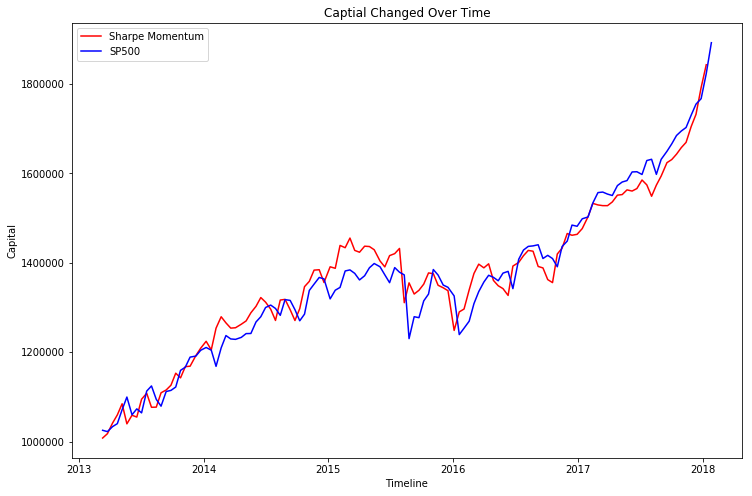

In [21]:
plt.figure(figsize=[12,8])
plt.plot(capital_change, color = 'red', label = 'Sharpe Momentum')
plt.plot(SP500_capital[index.isin(timeline)], color = 'blue', label = 'SP500')
plt.xlabel('Timeline')
plt.ylabel('Capital')
plt.title('Captial Changed Over Time')
plt.legend(loc = 'best')
plt.show()

In [46]:
strategy_return = ((capital_change.values[-1] - capital_change.values[0]) / capital_change.values[0])[0]
market_return = ((SP500_capital.values[-1] - SP500_capital.values[0]) / SP500_capital.values[0])[0]
yearly_strategy_return = (strategy_return + 1) ** (1/5) - 1
yearly_market_return = (market_return + 1) ** (1/5) - 1
print('Market yearly return is %.3f' % yearly_market_return)
print('Sharpe Momentum Strategy return is %.3f' % yearly_strategy_return)

Market yearly return is 0.121
Sharpe Momentum Strategy return is 0.128


In [111]:
# beta 
beta = np.cov(capital_change['Capital'].values,SP500_capital[index.isin(timeline)]['Capital'][:-1].values)[0][1] / np.var(SP500_capital[index.isin(timeline)]['Capital'][:-1].values)
rf = 0.0234 # three month treasury bill rate
# alpha
alpha = yearly_strategy_return - rf - beta * (yearly_market_return - rf)
# volatility
volatility = np.std(capital_change.pct_change().dropna()['Capital'].values)
# sharpe ratio
sharpe_ratio = yearly_strategy_return / volatility
# information ratio
IR = (yearly_strategy_return - yearly_market_return) / np.std(capital_change.pct_change().dropna()['Capital'].values-SP500_capital[index.isin(timeline)][:-1].pct_change().dropna()['Capital'].values) 
# maximum drawdown
i = np.argmax(np.maximum.accumulate(capital_change['Capital'].values) - capital_change['Capital'].values) # end of the period
j = np.argmax(capital_change['Capital'].values[:i]) # start of period
max_drawdown = 100 * (capital_change['Capital'][i]-capital_change['Capital'][j]) / capital_change['Capital'][j] 

info = pd.DataFrame([yearly_strategy_return,
                     beta,
                     alpha,
                     volatility,
                     sharpe_ratio,
                     IR,
                     max_drawdown]).T
info.columns = ['Return','Beta','Alpha','Volatility','Sharpe Ratio','IR','Max Drawdown']

info.index = ['Info']
info

,Return,Beta,Alpha,Volatility,Sharpe Ratio,IR,Max Drawdown
Info,0.128326,0.934047,0.014186,0.019708,6.511292,0.261799,-14.200217
